<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/Transfer_Learning_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

In [ ]:
import tensorflow as tf

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-04-29 05:54:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   101MB/s    in 1.6s    

2024-04-29 05:54:18 (101 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
!ls 10_food_classes_10_percent

test  train


In [ ]:
import os

## walking through the directories to get the info
for dir_path, dir_names, file_name in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dir_names)} and {len(file_name)} images in {dir_path}")

There are 2 and 0 images in 10_food_classes_10_percent
There are 10 and 0 images in 10_food_classes_10_percent/train
There are 0 and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 and 75 images in 10_food_classes_10_percent/train/steak
There are 0 and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 10 and 0 images in 10_food_classes_10_percent/test
There are 0 and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 and 250 images in 10

we have less training data than the test data

## Creating a Data loader
using `ImageDataGenerator`

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

training_data = train_datagen.flow_from_directory(directory=train_dir,
                                                  shuffle=True,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical')

testing_data = test_datagen.flow_from_directory(directory=test_dir,
                                                shuffle=True,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callback (things to run whilst our model trains)

callbacks are extra functionality you can add to our models to be performed during or after training.

Some of the most popular callbacks:
* Tracking experiments while the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping the model from training (before it trains too long and overfit) with the EarlyStopping callback.

In [ ]:
## Creating a TensorBoard callback (functionalized, because we need to create a new one for each model)
import datetime as dt

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name +'/'+ experiment_name +'/'+ dt.datetime.now().strftime("%Y%m%d-%H%m%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

## Creating Models using TensorFlow Hub

we can access model in TensorFlow Hub


In [ ]:
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"

efficient_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_Classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, ## Freeze already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=(224, 224, 3))

  # Create model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing Resnet TensorFlow Hub Feature Extraction model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
## Compile a model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
history = resnet_model.fit(training_data,
                           epochs=5,
                           callbacks=[create_tensorboard_callback('Transfer_learning', 'resnet_model')])

Saving TensorBoard log files to Transfer_learning/resnet_model/20240429-05041714370069
Epoch 1/5
24/24 [==============================] - 125s 5s/step - loss: 1.9155 - accuracy: 0.3480
Epoch 2/5
24/24 [==============================] - 119s 5s/step - loss: 0.8764 - accuracy: 0.7373
Epoch 3/5
24/24 [==============================] - 123s 5s/step - loss: 0.5923 - accuracy: 0.8453
Epoch 4/5
24/24 [==============================] - 128s 5s/step - loss: 0.4556 - accuracy: 0.8933
Epoch 5/5
24/24 [==============================] - 120s 5s/step - loss: 0.3644 - accuracy: 0.9280


In [ ]:
resnet_model.evaluate(testing_data)

79/79 [==============================] - 408s 5s/step - loss: 0.6842 - accuracy: 0.7776


[0.6842128038406372, 0.7775999903678894]

<Axes: >

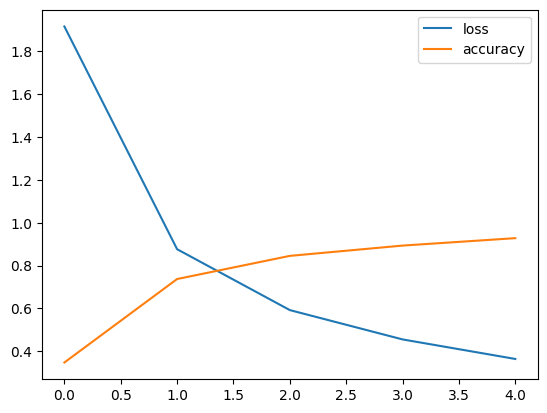

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot()

In [ ]:
## effientnet model

efficient_model = create_model(efficient_url, 10)

In [ ]:
efficient_model.compile(loss='categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
history_1 = efficient_model.fit(training_data,
                                epochs=5,
                                validation_data=testing_data,
                                callbacks=[create_tensorboard_callback('transfer_learning', 'efficient_net')])

Saving TensorBoard log files to transfer_learning/efficient_net/20240429-06041714371155
Epoch 1/5
24/24 [==============================] - 191s 8s/step - loss: 2.0435 - accuracy: 0.3573 - val_loss: 1.2508 - val_accuracy: 0.5808
Epoch 2/5
24/24 [==============================] - 183s 8s/step - loss: 1.0351 - accuracy: 0.6667 - val_loss: 0.8980 - val_accuracy: 0.6988
Epoch 3/5
24/24 [==============================] - 181s 8s/step - loss: 0.7666 - accuracy: 0.7640 - val_loss: 0.8069 - val_accuracy: 0.7200
Epoch 4/5
24/24 [==============================] - 166s 7s/step - loss: 0.6259 - accuracy: 0.8147 - val_loss: 0.7649 - val_accuracy: 0.7368
Epoch 5/5
24/24 [==============================] - 174s 7s/step - loss: 0.5420 - accuracy: 0.8440 - val_loss: 0.7580 - val_accuracy: 0.7424


In [ ]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              7200312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [ ]:
df = pd.DataFrame(history_1.history)

### Different types of Transfer Learning

* **As is Transfer learning** -
* **Feature Extraction Transfer learninig** - use prelearned patterns of existing an model and adjust output layer for your own problem
* **Fine Tunning Transfer learning**  - here we can "Fine-tune" many or all the underlying layers.
